# Machine Learning LAB 3: CLASSIFICATION - Characters Classification with Neural Networks

Course 2024/25: *M. Caligiuri*, *M. Pavan*, *P. Zanuttigh*

The notebook contains some simple classification tasks to be performed with neural networks.

Complete the **required code sections** and **answer to the questions**.


## Characters Classification with Neural Networks

In this notebook we are going to use the **Neural Networks** for image classification. We are going to use a dataset of traditional japanese handwritten kana: [*Kuzushiji-MNIST*](https://github.com/rois-codh/kmnist) (or *K-MNIST* for short).

The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>

**Student name**: Tommaso Tombolato

**ID Number**: 2104231

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline  

import os
import gzip
from time import time
from copy import deepcopy as cp
import typing as tp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

---

## Define the helper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `load_mnist` -> function to load the K-MNIST dataset,
2. `plot_input` -> function to plot the input image,
3. `param_count`-> function to compute the number of learnable parameters of a MLP given the size of its hidden layers,
4. `plot_accuracies` -> function to plot the accuracies of the MLP,
5. `plot_losses` -> function to plot the losses of the MLP,
6. `plot_conf_matrix` -> function to plot the confusion matrix of the MLP.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
def load_kmnist(path: str, kind: str = 'train') -> tp.Tuple[np.ndarray, np.ndarray]:
    # Define the path to the data
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    
    # Load the data into numpy arrays (from the gzip files)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    
    return images, labels

In [3]:
#function for plotting a image and printing the corresponding label
def plot_input(data: np.ndarray, labels: np.ndarray, index: int or tp.List[int]) -> None:
    if isinstance(index, int):
        index = [index]

    _, ax = plt.subplots(1, len(index), figsize=(len(index) * 2, 2))

    if len(index) == 1:
        ax = [ax]  # ensure ax is always iterable

    for i, idx in enumerate(index):
        ax[i].imshow(data[idx].reshape(28, 28), cmap=plt.cm.gray_r, interpolation="nearest")
        ax[i].set_title(f"Label: {labels[idx]}")
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    plt.tight_layout()
    plt.show()
    plt.close()
    

In [4]:
def param_count(hl_size: int, x: np.ndarray, y: np.ndarray) -> int:
    tot = 0
    input_size, output_size = x.shape[1], len(y)
    tot += (input_size+1)*hl_size[0]
    for i in range(1,len(hl_size)):
        tot += (hl_size[i-1]+1)*hl_size[i]
    tot += (hl_size[-1]+1)*output_size
    return tot

In [5]:
def plot_accuracies(accuracies: tp.List[float], hl_labels: tp.List[str], titles: tp.List[str] = None) -> None:
    _, ax = plt.subplots(1, len(accuracies), figsize=(6 * len(accuracies), 5))

    if type(ax) != np.ndarray:
        ax = [ax]
    
    for i, ax in enumerate(ax):
        ax.plot(accuracies[i])
        ax.set_xlabel("Number of learnable params")
        ax.set_title("Accuracy")
        ax.set_xticks(np.arange(0,len(hl_labels[i])))
        ax.set_xticklabels(hl_labels[i])
        if titles is not None:
            ax.set_title(titles[i])
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def plot_loss(losses: tp.Dict[float, np.ndarray]) -> None:
    legend = True

    # Plot all the losses
    for key, value in losses.items():
        if key == None:
            plt.plot(value)
            legend = False
        else:
            plt.plot(value, label=f"lr: {key}")

    # Plot the legend, title and labels
    plt.title("Losses")
    if legend:
        plt.legend(loc = 1)
    plt.xlabel("Number of iterations")
    plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()
    plt.close()

In [7]:
def plot_conf_matrix(conf_matrix: np.ndarray) -> None:
    # Plot the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d",)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.tight_layout()
    plt.show()
    plt.close()

---

## Classification with Neural Networks (using Scikit-Learn)

In the first part of this notebook we are going to implement a simple *MLP* using the *Scikit-Learn* library.

### TO DO (A.0)
    
**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: $1234567 + 1$

In [8]:
# Fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2104231 #+ 5678  # insert your ID number here
np.random.seed(ID)

Now load the dataset using the `load_mnist` function and rescale the data in the range [0,1].

In [9]:
# Load the data
x, y = load_kmnist("data")

# Print the number of samples in the dataset
print("Number of samples in the MNIST dataset:", x.shape[0])

# Print the minimum and maximum values of the input
print("Minimum and maximum values of the input:", np.min(x), np.max(x))

# Rescale the data in [0,1]
x = x / 255.0

# Print the minimum and maximum values of the input after rescaling
print("Minimum and maximum values of the input after rescaling:", np.min(x), np.max(x))

Number of samples in the MNIST dataset: 60000
Minimum and maximum values of the input: 0 255
Minimum and maximum values of the input after rescaling: 0.0 1.0


Now split into training and test. We start with a small training set of $600$ samples to reduce computation time while $4000$ samples will be used for testing. Make sure that each label is present at least $10$ times in training frequencies.

In [10]:
# Random permute the data (both train and test set) and split into training and
# test taking the first 600 data samples as training and the rests as test
loop = True

while loop:
    loop = False
    # Create a list of indices
    idx = np.arange(x.shape[0])
    # Randomly shuffle the indices
    np.random.shuffle(idx)
    # Shuffle the dataset
    x = x[idx]
    y = y[idx]
    
    x_train = x[0:600, : ]
    y_train = y[0:600]
    
    x_test = x[600:1000, : ]
    y_test = y[600:1000]
    
    # Print the number of unique labels (with the correspondent 
    # frequency) in the training set and in the test set
    print("x_train shape:", x_train.shape,"x_test shape:", x_test.shape,"||","y_train shape:",  y_train.shape,"y_test shape:", y_test.shape)
    
    labels, freqs = np.unique(y_train, return_counts=True) # np.unique(y_train, return_counts=True) restituisce due array: labels: le etichette uniche presenti in y_train. freqs: il numero di volte che ogni etichetta appare in y_train.
    print("Labels in training dataset: ", labels)
    print("Frequencies in training dataset: ", freqs)
    for i in range(len(labels)):
        if freqs[i] < 10:
            loop = True
            break

x_train shape: (600, 784) x_test shape: (400, 784) || y_train shape: (600,) y_test shape: (400,)
Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [58 72 58 63 70 53 64 56 53 53]


Plot three samples from the dataset, together with their label (use the function))

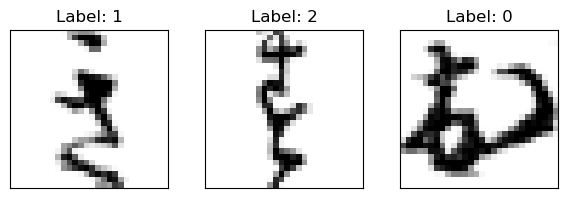

In [11]:
# Suggestions: use the plot_input function
# Scegli tre indici casuali distinti tra 0 e 599
indices = np.random.choice(x_train.shape[0], size=3, replace=False)
plot_input(x_train, y_train, indices)

### TO DO (A.1)

Now use a feed-forward Neural Network for prediction. Use the multi-layer perceptron classifier, with the following parameters: max_iter = $200$, alpha = $1 \cdot 10^{-4}$, solver = 'sgd', tol = $1 \cdot 10^{-4}$, learning_rate_init = $0.1$, random_state = ID (this last parameter ensures the run is the same even if you run it more than once). The alpha parameter is the regularization term.

Then, using the default activation function, pick four or five architectures to consider, with different numbers of hidden layers and different sizes. It is not necessary to create huge neural networks, you can limit to $3$ layers and, for each layer, its maximum size can be of $50$. Evaluate the architectures you chose using GridSearchCV with cv = $5$.

You can reduce the number of iterations if the running time is too long on your computer.

In [12]:
# These are sample values but feel free to change them as you like,
# try to experiment with different sizes!!
parameters = {'hidden_layer_sizes': [(10,), (20,), (40,), (20,20,), (40,20,10), (10,40,10), (50,)]}

# Create a MLP classifier using scikit-learn
MLP = MLPClassifier(solver='sgd', alpha=0.0001, learning_rate_init=0.1, max_iter=200, random_state=ID, tol=0.0001)

# Perform a grid search varying over the given parameters
grid_mlp = GridSearchCV(estimator = MLP, param_grid = parameters, cv = 5, n_jobs=-1)

# traning
grid_mlp.fit(x_train, y_train)

# Print the best estimator parameters
print("Best hidden_layer_sizes:", grid_mlp.best_params_['hidden_layer_sizes'])
print("Best score: ", grid_mlp.best_score_)

Best hidden_layer_sizes: (40,)
Best score:  0.7666666666666667


### TO DO (A.Q1) [Answer the following] 

What do you observe for different architectures? How do the number of layers and their sizes affect the performances?

**ANSWER A.Q1:** Answer here

### TO DO (A.2)

Plot the train and test accuracies as a function of the numbero of neurons in your neural network. Print also the computation time for the various configuration you try.

While performing the *MLP* train with different hidden layer sizes evaluate also the time spend for the training by each different configuration. You can use the `time` library to measure the time spent for the training.

In particular if you want to estimate the time elapsed for the execution of a function you can use the following code:

```python
# Import the time library
from time import time
# Define the starting time
start_time = time()
# Execute the function
function_to_evaluate()
# Compute the elapsed time
elapsed_time = time() - start_time
```

As you can see for the example above the `time()` function returns the time in seconds since the epoch as a floating point number. So, to compute the elapsed time we can simply compute the difference between the time after the execution of the function and the time before the execution of the function.

Keep in mind that to use the `time()` function we need to import the `time` library (already done at the beginning of this notebook).

Training MLP of size 10 ...
Traninf time:  1.6860020160675049
Training MLP of size 20 ...
Traninf time:  0.9947509765625
Training MLP of size 40 ...
Traninf time:  1.2194945812225342
Training MLP of size 20 ...
Traninf time:  0.5858309268951416
Training MLP of size 30 ...
Traninf time:  1.2892544269561768


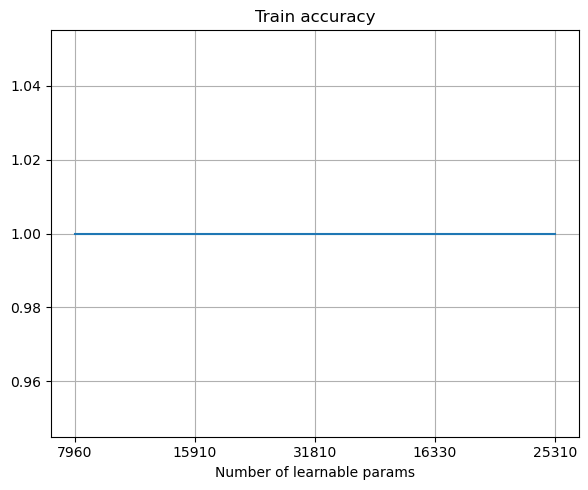

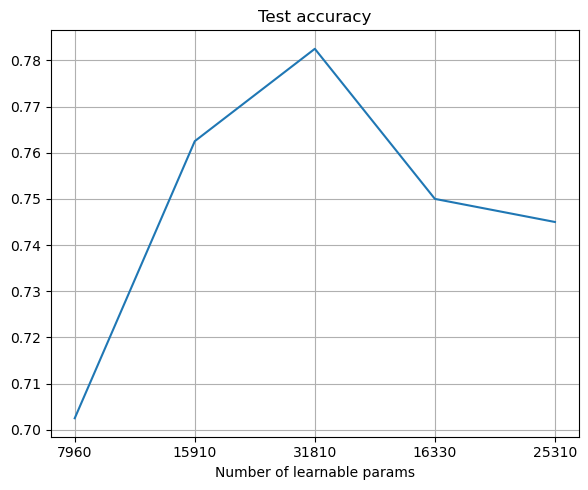

In [13]:
# Define the list of hidden layer sizes to try out (feel free to change)
# Define also the labels for the plot
hl_sizes = [(10,), (20,), (40,), (20,20,), (30,30,20)]
hl_labels = [param_count(t, x_train, labels) for t in hl_sizes]

train_acc_list, test_acc_list = [], []  # lists for saving accuracies (train and test)

for hl_size in hl_sizes:
    # Train the MLPs with the different hidden layers sizes and get the accuracies
    s_time = time()  # start time
    
    print(f"Training MLP of size {hl_size[0]} ...")

    # Define the MLP object
    MLP = MLPClassifier(hidden_layer_sizes = hl_size, solver='sgd', alpha=0.0001, learning_rate_init=0.1, max_iter=200, random_state=ID, tol=0.0001)

    # Train the MLP
    MLP.fit(x_train, y_train)

    # Predict
    #y_pred = MLP.predict(x_test)

    # Save the accuracies in the correct lists
    train_acc_list.append(MLP.score(x_train, y_train))
    test_acc_list.append( MLP.score(x_test, y_test))
                          
    # Print the time needed for training
    elapsed_time = time() - s_time
    print("Traninf time: ", elapsed_time)

# Plot the train and test accuracies
# Suggestions: use the plot_accuracies function
#print("train_acc_list.len= ", len(test_acc_list))
#print("hl_labels.len= ", len(hl_labels))

plot_accuracies([train_acc_list], [hl_labels], titles=["Train accuracy"])
plot_accuracies([test_acc_list], [hl_labels], titles=["Test accuracy"])

### TO DO (A.Q2) [Answer the following]

Comment about the training and test accuracies referring to the discussion on underfitting and overfitting we did in the course

**ANSWER A.Q2:** Answer here

### TO DO (A.3)

Now try also to use different learning rates, while keeping the best *NN* architecture and batch size you have found above. Plot the learning curves (*i.e.*, the variation of the loss over the steps, you can get it from the `loss_curve_` object of sklearn) for the different values of the learning rate. Try to run each training for $600$ iterations. Plot all the curves in the same plot.

Best learning rate: 0.02
Corresponding training accuracy: 0.9983


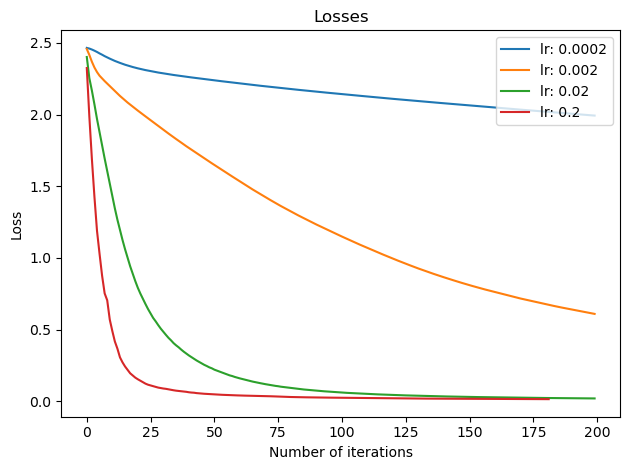

In [14]:
# Define the list of batch sizes to try out (feel free to change)
lr_list = [0.0002, 0.002, 0.02, 0.2]

# Train the MLPs with the different lerning rates
scores = {}  # dictionary for saving the scores
losses = {}  # dictionary for saving losses

# Get the best hidden layer sizes and batch size from the previous MLPs
best_index = train_acc_list.index(max(train_acc_list))

for lr in lr_list:
    # Define the MLP object
    MLP = MLPClassifier(hidden_layer_sizes=hl_sizes[best_index], batch_size='auto', solver='sgd', alpha=0.0001, learning_rate_init=lr, max_iter=200, random_state=ID, tol=0.0001)

    # Train the MLP
    MLP.fit(x_train, y_train)

    # Save the score and the loss in the correct dictionary
    scores[lr] = MLP.score(x_train, y_train)
    losses[lr] = MLP.loss_curve_  # usa la curva di loss vera, non 1 - accuracy # 1 - MLP.score(x_train, y_train)

# Print the best learning rate value and the corresponding score
best_lr = max(scores, key=scores.get)
best_score = scores[best_lr]

print(f"Best learning rate: {best_lr}")
print(f"Corresponding training accuracy: {best_score:.4f}")

# Plot the losses
# Suggestions: use the plot_loss function
plot_loss(losses)

### TO DO (A.Q3) [Answer the following]

Comment about the learning curves (*i.e.*, the variation of the loss over the steps). How does the curve changes for different learning rates in terms of stability and speed of convergence?

**ANSWER A.Q3:** Answer here

### TO DO (A.4)

Now get training and test error for a NN with best parameters (architecture, batch size and learning rate) from above. Plot the learning curve also for this case.

Traning error:  0.0016666666666667052
Test error:  0.275


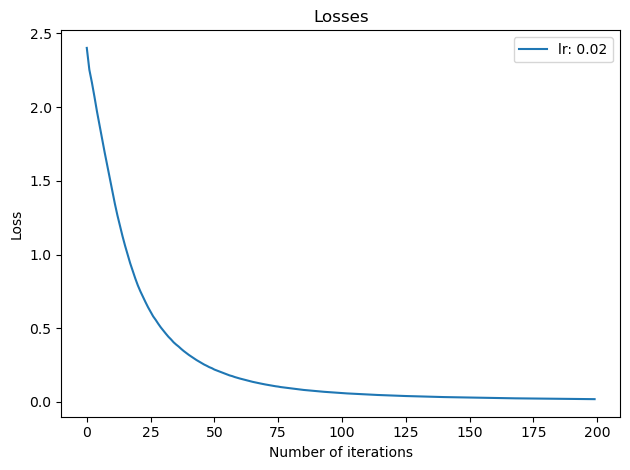

In [15]:
#get training and test error for the best NN model from CV
# Define the MLP object
MLP = MLPClassifier(hidden_layer_sizes=hl_sizes[best_index], batch_size='auto', solver='sgd', alpha=0.0001, learning_rate_init=best_lr, max_iter=200, random_state=ID, tol=0.0001)

# Train the MLP
MLP.fit(x_train, y_train)

# Compute the training and test error
train_error = 1 - MLP.score(x_train, y_train)
test_error = 1 - MLP.score(x_test, y_test)

# Print the training and test error
print("Traning error: ", train_error)
print("Test error: ", test_error)

# Plot the loss curve for the best NN
# Suggestions: use the plot_loss function
plot_loss({best_lr: MLP.loss_curve_})  # wrap in dict to match expected format

### TO DO (A.5)

Compute and plot the confusion matrix for the best NN model from CV

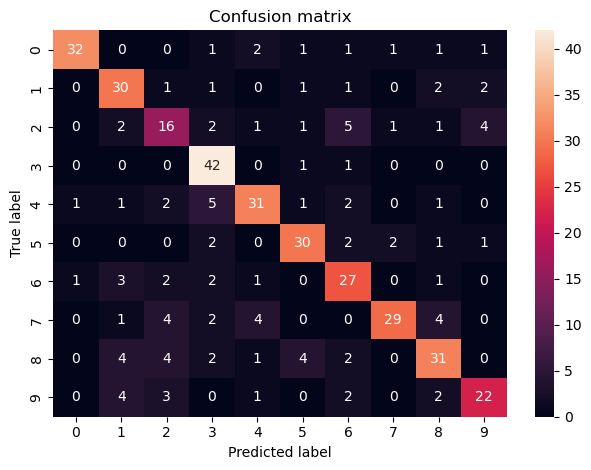

In [16]:
# Compute the confusion matrix
# ADD YOUR CODE HERE
y_pred = MLP.predict(x_test)
CM = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
# Suggestions: use the plot_conf_matrix function
plot_conf_matrix(CM)

---